In [22]:
from datasets import load_dataset
import polars as pl
from IPython.display import display, Markdown, Latex
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Dataset for ReflectionCoder
reflectioncoder_dataset = load_dataset("SenseLLM/ReflectionSeq-DS")

In [3]:
def _filter_python_only(row):
    for i, m in enumerate(row['messages']):
        for j, part in enumerate(m["content"]):
            if "python" in part["content"]:
                return True
    return False

def _explode_individual_messages(batch):
    out = {
        "messages": [],
    }
    for i, sample in enumerate(batch['messages']):
        all_parts = []
        for m in sample:
            for j, part in enumerate(m["content"]):
                all_parts.append({
                    "role": m["role"],
                    "content": part["content"],
                    'type': part['type']
                })
        out["messages"].append(all_parts)
    return out

reflectioncoder_dataset = reflectioncoder_dataset['train'].filter(_filter_python_only).map(_explode_individual_messages, batched=True).remove_columns(["type"])
ds_df = reflectioncoder_dataset.to_polars()


In [ ]:
ds_df.describe()

In [ ]:
def _display_messages_markdown(df):
    messages = df["messages"]
    for k, row in enumerate(messages):
        display(Markdown(f"# Row {k}"))
        for i, m in enumerate(row):
            display(Markdown(f"#### Message {i}: {m['role']}, {m['type']}"))
            content = m["content"].replace("#", "\#").replace("\n", "  \n")
            display(Markdown(content))


def _get_all_part_types(df):
    type_cts = defaultdict(int)
    for row in df["messages"]:
        for i, m in enumerate(row):
            msg_type, msg_role = m["type"], m["role"]
            type_cts[f"{msg_role}_{msg_type}"] += 1
    return type_cts


# _display_messages_markdown(ds_df[0:1])
display(_get_all_part_types(ds_df))

In [ ]:
from typing import List, Dict, Tuple

def process_reflection(sample: dict) -> Tuple[List[Dict[str, str]], Dict[str, str]]:

    # these fields are misnamed in the dataset
    for message in sample['messages']:
        msg_role, msg_type = message['role'], message['type']
        role_out = "assistant"
        print(message['role'], message['type'])

    return (
        conversation,
        {
            "role": "assistant",
            "content": markdown_json(sample_data),
        },
    )

display(process_reflection(reflectioncoder_dataset[0]))

In [2]:
reflection_dataset = load_dataset("glaiveai/reflection-v1")
reflection_dataset_pd = reflection_dataset['train'].to_polars()

In [ ]:
import polars as pl

def _display_reflection_v1_markdown(df: pl.DataFrame):
    for i, row in enumerate(df.to_dicts()):
        display(Markdown(f"# Row {i}"))
        display(Markdown(f"#### system: {row['system']}"))
        display(Markdown(f"#### Prompt: {row['prompt']}"))
        display(Markdown(f"#### Response: {row['response']}"))
_display_reflection_v1_markdown(reflection_dataset_pd[0:5])

In [8]:
humaneval_dataset = load_dataset("openai/openai_humaneval")

In [ ]:
import ast
from transformers.agents.python_interpreter import (
    evaluate_python_code,
    LIST_SAFE_MODULES,
)
import traceback

ALLOWED_FNS = {
    range,
    print,
    sum,
    enumerate,
    int,
    str,
    abs,
    zip,
    sorted,
    list,
    len,
    bin,
    isinstance,
    set,
    min,
    max,
    dict,
    filter,
    reversed,
    chr,
    ord,
    tuple,
    map,
    round
}
ALLOWED_FN_DICT = {fn.__name__: fn for fn in ALLOWED_FNS}

# TODO execute tests
failed = []

SKIP_LIST = set(['HumanEval/32', 'HumanEval/38', 'HumanEval/50', 'HumanEval/75', 'HumanEval/99', 'HumanEval/104', 'HumanEval/105', 'HumanEval/126', 'HumanEval/137', 'HumanEval/145', 'HumanEval/150', 'HumanEval/160', 'HumanEval/162'])

for i, sample in enumerate(humaneval_dataset["test"]):
    prompt, solution, task_id = sample["prompt"], sample["canonical_solution"], sample["task_id"]
    tests, entrypoint = sample["test"], sample["entry_point"]
    if task_id in SKIP_LIST:
        continue
    prompt = prompt.replace(">>>", "\n")
    tests = tests.replace("candidate(", entrypoint + "(")
    full_code = prompt + solution + tests + "\ncheck()"
    # display(Markdown(f"```{full_code}```"))
    auth_imports = LIST_SAFE_MODULES + ["typing", "copy", "hashlib", "string", "collections"]
    # print(auth_imports)
    try:
        fn = evaluate_python_code(
            full_code,
            ALLOWED_FN_DICT,
            authorized_imports=auth_imports,
        )
        print(f"result for {i}: {fn}")
    except Exception as e:
        # print(full_code)
        # traceback.print_exc()
        failed.append(sample['task_id'])

print(f"{len(failed)} / {len(humaneval_dataset['test'])} failed")
print(failed)

In [3]:
cc_dataset = load_dataset("deepmind/code_contests")["train"]

In [15]:
test_counts = []
for row in tqdm(cc_dataset):
    n_public = len(row['public_tests']['input'])
    n_private = len(row['private_tests']['input'])
    test_counts.append((n_public, n_private))

100%|██████████| 13328/13328 [00:51<00:00, 258.47it/s]


[ 1.97734094 14.77716086] [ 1.04796282 28.08766151]


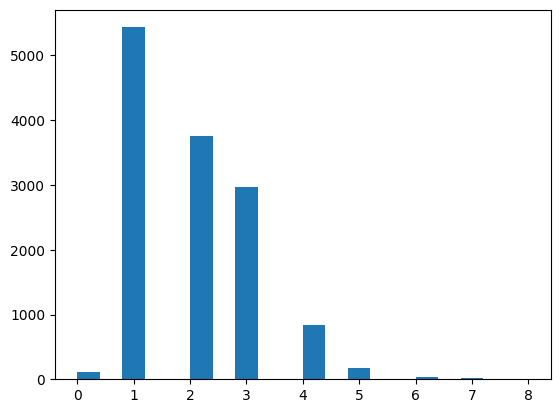

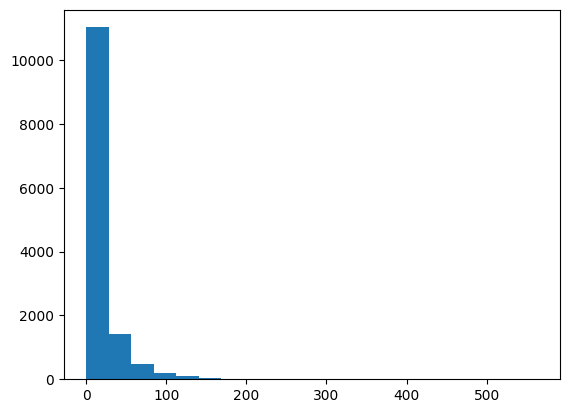

In [31]:
test_counts_np = np.array(test_counts)
print(test_counts_np.mean(axis=0), test_counts_np.std(axis=0))

plt.hist(test_counts_np[:, 0], bins=20)
plt.show()
plt.hist(test_counts_np[:, 1], bins=20)
plt.show()